In [63]:
# Reading EDF files requires the mne module 
import mne
import matplotlib.pyplot as plt
import numpy as np

The documentation of MNE can be found on [this web site](https://mne.tools) and more precisely [to read EDF files](https://mne.tools/dev/generated/mne.io.read_raw_edf.html). You also look at [this tutorial](https://mne.tools/dev/auto_tutorials/clinical/60_sleep.html#sphx-glr-auto-tutorials-clinical-60-sleep-py)


In the first section, the access to raw data is described. For the machine learning experiments, we will use already prepared files: subsampled, segments of 30s, all in numpy arrays. 


# Reading raw data

The dataset can be downloaded from this [link](https://www.physionet.org/content/sleep-edfx/1.0.0/). There is also a useful description on this page. All the data represents more than 8GB in their raw format. 

## Overview of the dataset
It gathers two datasets: Cassette and Telemetry. 

### Sleep Cassette Study and Data

The 153 `SC*` files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape.
Files are named in the form `SC4ssNEO-PSG.edf` where `ss` is the subject number, and `N` is the night. 

### Sleep Telemetry Study and Data

The 44 `ST*` files (ST = Sleep Telemetry) were obtained in a 1994 study of temazepam effects on sleep in 22 Caucasian males and females without other medication. Subjects had mild difficulty falling asleep but were otherwise healthy. The PSGs of about 9 hours were recorded in the hospital during two nights, one of which was after temazepam intake, and the other of which was after placebo intake. Files are named in the form `ST7ssNJ0-PSG.edf` where `ss` is the subject number, and `N` is the night.


## Access to some raw files
If you just want to access to some raw files, the `mne` API allows you to fetch some files by providing a list of subjects like this:

In [70]:
from mne.datasets.sleep_physionet.age import fetch_data

files = fetch_data(subjects=[12], recording=[1])

Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|█████████████████████████████████████| 50.8M/50.8M [00:00<00:00, 28.7GB/s]
100%|█████████████████████████████████████| 4.01k/4.01k [00:00<00:00, 2.53MB/s]

Download complete in 01m55s (48.5 MB)


## Visualization 

Assume you downloaded some raw data files. 

In [74]:
# Look at Telemetry 
datad="./org-data/sleep-edf-database-expanded-1.0.0/"
file = datad+"sleep-telemetry/ST7011J0-PSG.edf"
data = mne.io.read_raw_edf(file, preload=True)
raw_data = data.get_data()
print("*** type=", type(raw_data), ", taille = ", raw_data.size, ", dims = ", raw_data.shape)
# You can get the metadata included in the file and a list of all channels:
print("*** info :", data.info)
print("*** channels :", data.ch_names)


Extracting EDF parameters from /home/allauzen/dev/edf/org-data/sleep-edf-database-expanded-1.0.0/sleep-telemetry/ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...
*** type= <class 'numpy.ndarray'> , taille =  17950000 , dims =  (5, 3590000)
*** info : <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental, Marker
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 800.0 Hz
 meas_date: 1994-07-12 23:00:00 UTC
 nchan: 5
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
*** channels : ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']


In [75]:
data.info['sfreq']

100.0

Text(0.5, 0, 'temps (h)')

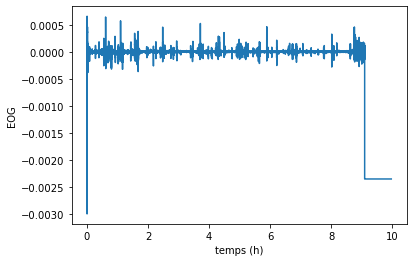

In [76]:
t=data.times
th = t/3600
eog = raw_data[3]
plt.plot(th,eog)
plt.ylabel("EOG")
plt.xlabel("temps (h)")

We can also look at the annotation:

In [77]:
# hypnogramme : on ajoute l'annotation à data
fileh = datad+"sleep-telemetry/ST7011JP-Hypnogram.edf"
annot = mne.read_annotations(fileh)
print(type(annot))
data.set_annotations(annot, emit_warning=True)
print(data.annotations[0]) 

for ann in data.annotations[:20]:
    descr = ann["description"]
    start = ann["onset"]
    end = ann["onset"] + ann["duration"]
    print("'{}' goes from {} to {}".format(descr, start, end))

<class 'mne.annotations.Annotations'>
OrderedDict([('onset', 0.0), ('duration', 1560.0), ('description', 'Sleep stage W'), ('orig_time', datetime.datetime(1994, 7, 12, 23, 0, tzinfo=datetime.timezone.utc))])
'Sleep stage W' goes from 0.0 to 1560.0
'Sleep stage 1' goes from 1560.0 to 1650.0
'Sleep stage 2' goes from 1650.0 to 2220.0
'Sleep stage 1' goes from 2220.0 to 2340.0
'Sleep stage 2' goes from 2340.0 to 2400.0
'Sleep stage 3' goes from 2400.0 to 2460.0
'Sleep stage 1' goes from 2460.0 to 2490.0
'Sleep stage 2' goes from 2490.0 to 2640.0
'Sleep stage 3' goes from 2640.0 to 2730.0
'Sleep stage 2' goes from 2730.0 to 2760.0
'Sleep stage 1' goes from 2760.0 to 2790.0
'Sleep stage 2' goes from 2790.0 to 2880.0
'Sleep stage W' goes from 2880.0 to 3000.0
'Sleep stage 1' goes from 3000.0 to 3060.0
'Sleep stage 2' goes from 3060.0 to 3300.0
'Sleep stage W' goes from 3300.0 to 3540.0
'Sleep stage 2' goes from 3540.0 to 3600.0
'Sleep stage 3' goes from 3600.0 to 3630.0
'Sleep stage 2' goes 

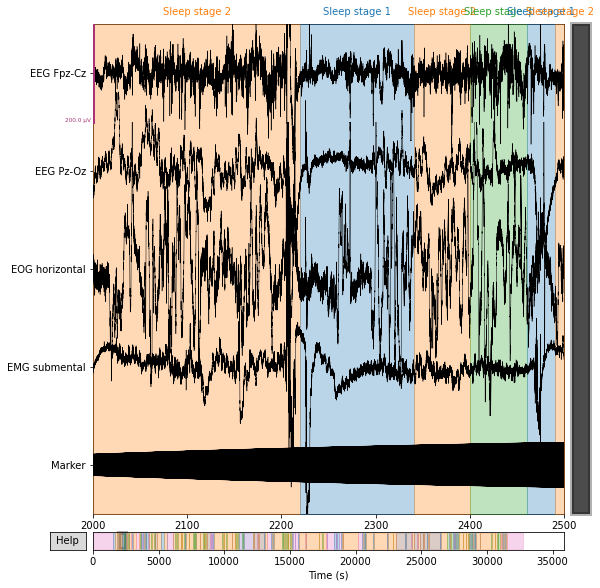

In [78]:
_ = data.plot(
    start=2000,
    duration=500,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
)

Of course we can do the same for the Cassette study, and we can also directly use `matplotlib`. 

Extracting EDF parameters from /home/allauzen/dev/edf/org-data/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
*** type= <class 'numpy.ndarray'> , taille =  55650000 , dims =  (7, 7950000)
*** info : <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
*** channels : ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


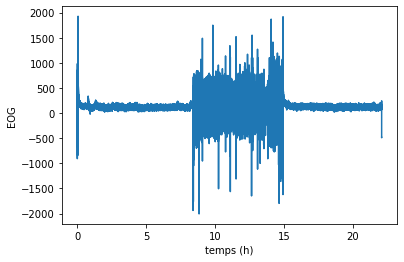

In [80]:
# PSG de cassette 
file = "./org-data/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf"
data = mne.io.read_raw_edf(file, preload=True)
raw_data = data.get_data()
print("*** type=", type(raw_data), ", taille = ", raw_data.size, ", dims = ", raw_data.shape)
# you can get the metadata included in the file and a list of all channels:
print("*** info :", data.info)
print("*** channels :", data.ch_names)
t=data.times
th = t/3600
eog = raw_data[3]
_ = plt.plot(th,eog)
_ = plt.ylabel("EOG")
_ = plt.xlabel("temps (h)")